# Importing libraries and datasets

In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import warnings

pd.set_option("display.max_columns", None)
pd.set_option("display.width", 500)
warnings.filterwarnings("ignore")

In [2]:
train = pd.read_csv("/kaggle/input/demand-forecasting-kernels-only/train.csv", parse_dates=["date"])
test = pd.read_csv("/kaggle/input/demand-forecasting-kernels-only/test.csv", parse_dates=["date"])

In [3]:
df = pd.concat([train, test], sort=False)

# Exploratory Data Analysis

In [4]:
df.shape

(958000, 5)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 958000 entries, 0 to 44999
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    958000 non-null  datetime64[ns]
 1   store   958000 non-null  int64         
 2   item    958000 non-null  int64         
 3   sales   913000 non-null  float64       
 4   id      45000 non-null   float64       
dtypes: datetime64[ns](1), float64(2), int64(2)
memory usage: 43.9 MB


In [6]:
display(df.head(3))

,date,store,item,sales,id
0,2013-01-01,1,1,13.0,NaN
1,2013-01-02,1,1,11.0,NaN
2,2013-01-03,1,1,14.0,NaN


In [7]:
display(df.tail(3))

,date,store,item,sales,id
44997,2018-03-29,10,50,NaN,44997.0
44998,2018-03-30,10,50,NaN,44998.0
44999,2018-03-31,10,50,NaN,44999.0


In [8]:
display(df.describe().T)

,count,mean,min,25%,50%,75%,max,std
date,958000,2015-08-16 11:59:59.999999744,2013-01-01 00:00:00,2014-04-24 18:00:00,2015-08-16 12:00:00,2016-12-07 06:00:00,2018-03-31 00:00:00,NaN
store,958000.0,5.5,1.0,3.0,5.5,8.0,10.0,2.872283
item,958000.0,25.5,1.0,13.0,25.5,38.0,50.0,14.430877
sales,913000.0,52.250287,0.0,30.0,47.0,70.0,231.0,28.801144
id,45000.0,22499.5,0.0,11249.75,22499.5,33749.25,44999.0,12990.525394


In [9]:
df.isnull().sum()

date          0
store         0
item          0
sales     45000
id       913000
dtype: int64

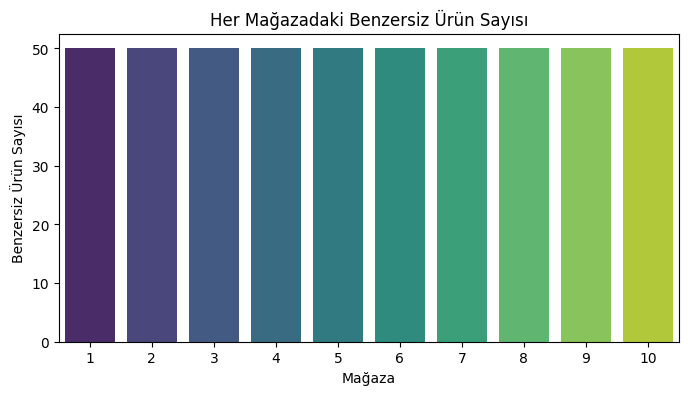

In [10]:
# Her mağazada benzersiz ürün sayısını hesaplama
unique_items_per_store = df.groupby(["store"])["item"].nunique().reset_index()
unique_items_per_store.columns = ['store', 'unique_items']

# Bar Plot ile görselleştirme
plt.figure(figsize=(8, 4))
sns.barplot(x="store", y="unique_items", data=unique_items_per_store, palette="viridis")
plt.title('Her Mağazadaki Benzersiz Ürün Sayısı')
plt.xlabel('Mağaza')
plt.ylabel('Benzersiz Ürün Sayısı')
plt.show()

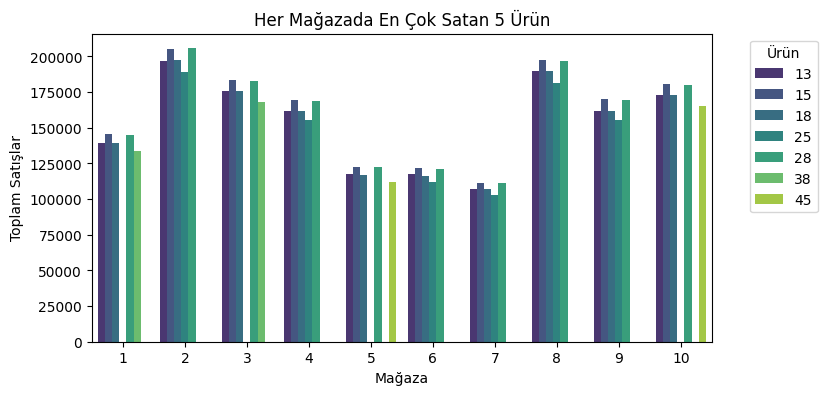

In [11]:
# Her mağazada en çok satan 5 ürünü belirleme
grouped_df = df.groupby(["store", "item"]).agg({"sales": "sum"}).reset_index()

top5_items_per_store = grouped_df.groupby("store").apply(lambda x: x.nlargest(5, 'sales')).reset_index(drop=True)

# Bar Plot ile görselleştirme
plt.figure(figsize=(8, 4))
sns.barplot(x="store", y="sales", hue="item", data=top5_items_per_store, palette="viridis")
plt.title('Her Mağazada En Çok Satan 5 Ürün')
plt.xlabel('Mağaza')
plt.ylabel('Toplam Satışlar')
plt.legend(title='Ürün', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

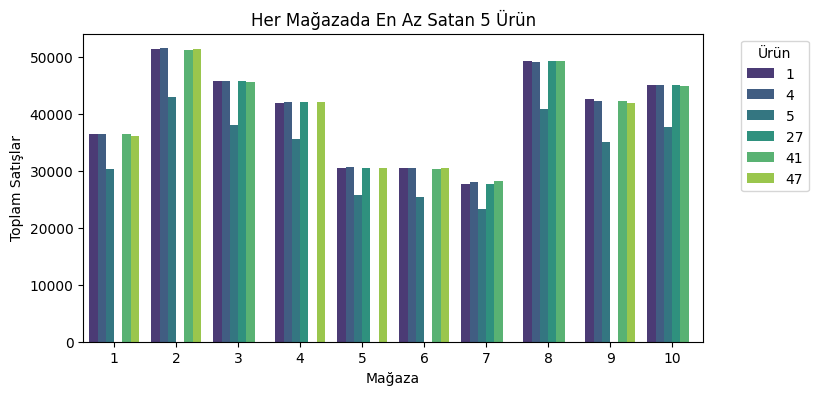

In [12]:
# En az satan 5 ürünü bulma
bottom5_items_per_store = grouped_df.groupby("store").apply(lambda x: x.nsmallest(5, 'sales')).reset_index(drop=True)

# Bar Plot ile görselleştirme
plt.figure(figsize=(8, 4))
sns.barplot(x="store", y="sales", hue="item", data=bottom5_items_per_store, palette="viridis")
plt.title('Her Mağazada En Az Satan 5 Ürün')
plt.xlabel('Mağaza')
plt.ylabel('Toplam Satışlar')
plt.legend(title='Ürün', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

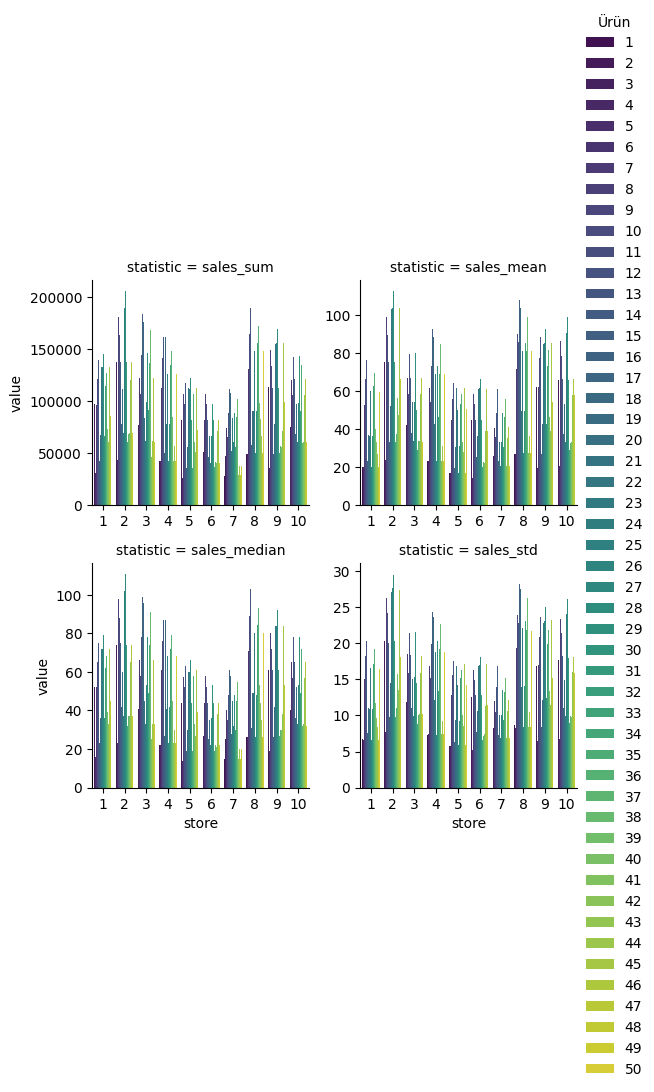

In [13]:
# Mağaza ürün kırılımında satış istatistikleri

# Grup ve istatistiksel değerleri hesaplama
agg_df = df.groupby(["store", "item"]).agg({"sales": ["sum", "mean", "median", "std"]}).reset_index()
agg_df.columns = ['store', 'item', 'sales_sum', 'sales_mean', 'sales_median', 'sales_std']

# FacetGrid ile Ayrı Ayrı İstatistikler
melted_df = agg_df.melt(id_vars=["store", "item"], value_vars=["sales_sum", "sales_mean", "sales_median", "sales_std"],
                        var_name="statistic", value_name="value")

g = sns.FacetGrid(melted_df, col="statistic", col_wrap=2, height=3, aspect=1, sharex=False, sharey=False)
g.map(sns.barplot, "store", "value", "item", palette="viridis")
g.add_legend(title='Ürün')
plt.show()

# Feature Engineering

## Date Features (Tarihsel Özellikler)

In [14]:
def create_date_features(df):
    df["month"] = df.date.dt.month # Ay
    df["day_of_month"] = df.date.dt.day # Ayın kaçıncı günü
    df["day_of_year"] = df.date.dt.dayofyear # Yılın kaçıncı günü
    df["day_of_week"] = df.date.dt.dayofweek # Haftanın kaçıncı günü
    df["week_of_year"] = df.date.dt.isocalendar().week # Yılın kaçıncı haftası
    df["year"] = df.date.dt.year # Yıl
    df["is_weeknd"] = df.date.dt.weekday // 4 # Hafta sonu mu?
    df["is_month_start"] = df.date.dt.is_month_start.astype(int) # Ay başı mı?
    df["is_mont_end"] = df.date.dt.is_month_end.astype(int) # Ay sonu mu?
    return df

In [15]:
df = create_date_features(df)

In [16]:
display(df.head(3))

,date,store,item,sales,id,month,day_of_month,day_of_year,day_of_week,week_of_year,year,is_weeknd,is_month_start,is_mont_end
0,2013-01-01,1,1,13.0,NaN,1,1,1,1,1,2013,0,1,0
1,2013-01-02,1,1,11.0,NaN,1,2,2,2,1,2013,0,0,0
2,2013-01-03,1,1,14.0,NaN,1,3,3,3,1,2013,0,0,0


In [17]:
# Mağaza, ürün, ay kırılımında satış istatistikleri
display(df.groupby(["store", "item", "month"]).agg({"sales": ["sum", "mean", "median", "std"]}))

sales                             
                      sum       mean median        std
store item month                                      
1     1    1       2125.0  13.709677   13.0   4.397413
           2       2063.0  14.631206   14.0   4.668146
           3       2728.0  17.600000   17.0   4.545013
           4       3118.0  20.786667   20.0   4.894301
           5       3448.0  22.245161   22.0   6.564705
...                   ...        ...    ...        ...
10    50   8      13108.0  84.567742   85.0  15.676527
           9      11831.0  78.873333   79.0  15.207423
           10     11322.0  73.045161   72.0  14.209171
           11     11549.0  76.993333   77.0  16.253651
           12      8724.0  56.283871   56.0  11.782529

[6000 rows x 4 columns]

## Random Noise (Rastgele Gürültü)

<p>Üretecek olduğumuz bu yeni gecikme (lag) özellikleri bağımlı değişken üzerinden üretileceği için modelde aşırı öğrenmeye yatkınlık olacaktır. Bu yatkınlığın önüne geçebilmek için veri setine rastgele gürültüler eklemek gerekmektedir. Bu gürültü ekleme işlemini ise random_noise fonksiyonu ile yapıyor olacağız.</p>

In [18]:
def random_noise(dataframe):
    return np.random.normal(scale=1.6, size=(len(dataframe),))

## Lag/Shifted Features (Gecikme/Değiştirilmiş Özellikler)

<p>Burada yapacak olduğumuz işlem geçmiş dönem satış sayılarına ilişkin özellikler türetmek. Bu özelliklerde "sales" değerlerinin önceki dönemlerdeki değerlerini oluşturuyor olacağız.</p>

In [19]:
# Bu özelliklerin oluşturulabilmesi için verinin mağaza, ürün ve tarihe göre sıralı olması gerekmektedir.
df.sort_values(by=["store", "item", "date"], axis=0, inplace=True)

In [20]:
display(pd.DataFrame({"sales": train["sales"].values[0:10], 
              "lag1": train["sales"].shift(1).values[0:10], # 1 gecikme almak demek ilgili değerin bir adım öncesindeki değeri almak demektir. 
              "lag2": train["sales"].shift(2).values[0:10], # 2 gecikme almak demek ilgili değerin iki adım öncesindeki değeri almak demektir.
              "lag3": train["sales"].shift(3).values[0:10], # 3 gecikme almak demek ilgili değerin üç adım öncesindeki değeri almak demektir.
              "lag4": train["sales"].shift(4).values[0:10]})) # 4 gecikme almak demek ilgili değerin dört adım öncesindeki değeri almak demektir

,sales,lag1,lag2,lag3,lag4
0,13,NaN,NaN,NaN,NaN
1,11,13.0,NaN,NaN,NaN
2,14,11.0,13.0,NaN,NaN
3,13,14.0,11.0,13.0,NaN
4,10,13.0,14.0,11.0,13.0
5,12,10.0,13.0,14.0,11.0
6,10,12.0,10.0,13.0,14.0
7,9,10.0,12.0,10.0,13.0
8,12,9.0,10.0,12.0,10.0
9,9,12.0,9.0,10.0,12.0


In [21]:
def lag_features(dataframe, lags):
    for lag in lags:
        dataframe["sales_lag_" + str(lag)] = dataframe.groupby(["store", "item"])["sales"].transform(lambda x: x.shift(lag)) + random_noise(dataframe)
    return dataframe

In [22]:
df = lag_features(df, [91, 98, 105, 112, 119, 126, 182, 364, 526, 728])

In [23]:
display(df.head(3))

,date,store,item,sales,id,month,day_of_month,day_of_year,day_of_week,week_of_year,year,is_weeknd,is_month_start,is_mont_end,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,sales_lag_364,sales_lag_526,sales_lag_728
0,2013-01-01,1,1,13.0,NaN,1,1,1,1,1,2013,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-01-02,1,1,11.0,NaN,1,2,2,2,1,2013,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2013-01-03,1,1,14.0,NaN,1,3,3,3,1,2013,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Rolling Mean Features (Hareketli Ortalama Özellikleri)

In [24]:
display(pd.DataFrame({"sales": train["sales"].values[0:10], 
              "roll2": train["sales"].rolling(window=2).mean().values[0:10], # İlgili değerin kendisi dahil 2 değer önceki değerlerin ortalaması
              "roll3": train["sales"].rolling(window=3).mean().values[0:10], # İlgili değerin kendisi dahil 3 değer önceki değerlerin ortalaması
              "roll5": train["sales"].rolling(window=5).mean().values[0:10]})) # İlgili değerin kendisi dahil 5 değer önceki değerlerin ortalaması

,sales,roll2,roll3,roll5
0,13,NaN,NaN,NaN
1,11,12.0,NaN,NaN
2,14,12.5,12.666667,NaN
3,13,13.5,12.666667,NaN
4,10,11.5,12.333333,12.2
5,12,11.0,11.666667,12.0
6,10,11.0,10.666667,11.8
7,9,9.5,10.333333,10.8
8,12,10.5,10.333333,10.6
9,9,10.5,10.000000,10.4


<p>Hareketli ortalama featurlarını yukarıdaki şekilde olduğu gibi türetmek hatalı bir kullanım olacaktır o yüzden bu featurları böyle değil, 1 adet gecikme aldıktan sonra türetmemiz gerekmektedir.</p>

In [25]:
display(pd.DataFrame({"sales": train["sales"].values[0:10], 
              "roll2": train["sales"].shift(1).rolling(window=2).mean().values[0:10], # İlgili değerin kendisinden önceki 2 değerin ortalaması
              "roll3": train["sales"].shift(1).rolling(window=3).mean().values[0:10], # İlgili değerin kendisinden önceki 3 değerin ortalaması
              "roll5": train["sales"].shift(1).rolling(window=5).mean().values[0:10]})) # İlgili değerin kendisinden öcenki 5 değerin ortalaması

,sales,roll2,roll3,roll5
0,13,NaN,NaN,NaN
1,11,NaN,NaN,NaN
2,14,12.0,NaN,NaN
3,13,12.5,12.666667,NaN
4,10,13.5,12.666667,NaN
5,12,11.5,12.333333,12.2
6,10,11.0,11.666667,12.0
7,9,11.0,10.666667,11.8
8,12,9.5,10.333333,10.8
9,9,10.5,10.333333,10.6


In [26]:
def roll_mean_features(dataframe, windows):
    for window in windows:
        dataframe["sales_roll_mean_" + str(window)] = dataframe.groupby(["store", "item"])["sales"].transform(lambda x: x.shift(1).rolling(window=window, min_periods=10, win_type="triang").mean()) + random_noise(dataframe)
    return dataframe

In [27]:
df = roll_mean_features(df, [365, 546]) # 1 yıl önceki ve 1.5 yıl önceki değerlerin toplamının hareketli ortalaması

In [28]:
display(df.tail(3))

,date,store,item,sales,id,month,day_of_month,day_of_year,day_of_week,week_of_year,year,is_weeknd,is_month_start,is_mont_end,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,sales_lag_364,sales_lag_526,sales_lag_728,sales_roll_mean_365,sales_roll_mean_546
44997,2018-03-29,10,50,NaN,44997.0,3,29,88,3,13,2018,0,0,0,58.564291,62.571814,75.677856,67.231807,75.187692,85.852864,81.781517,66.896663,79.738691,74.188486,85.037868,87.248059
44998,2018-03-30,10,50,NaN,44998.0,3,30,89,4,13,2018,1,0,0,76.028190,73.187882,72.421306,65.213870,67.189873,84.517664,90.749780,69.015232,88.949852,80.380830,90.014977,85.824887
44999,2018-03-31,10,50,NaN,44999.0,3,31,90,5,13,2018,1,0,1,61.530804,70.544821,53.575863,68.839899,52.277718,77.137437,101.308311,100.434310,80.124868,83.242616,89.132563,84.996759


## Exponentially Weighted Average Features (Üstel Ağırlıklı Ortalama Özellikleri)

<p>Üstel ağırlıklı ortalama (exponentially weighted average, EWA) zaman serisi tahminleme projelerinde önemli bir rol oynar. Bu yöntem, geçmiş verilerin daha güncel gözlemlere daha fazla ağırlık vererek kullanılması anlamına gelir.

Burada kaç adım öncesine gidilecek ve bu üstsel ağırlıklı ortalamalar için alpha değeri belirleme gibi problemlerimiz olacak. 
    
Bir diğer değişle gecikme sayısı (lags) ve alpha değerlerinin ne olacağını belirlememiz gerekecek.</p>

In [29]:
display(pd.DataFrame({"sales": train["sales"].values[0:10], 
              "roll2": train["sales"].shift(1).rolling(window=2).mean().values[0:10], 
              "emw099": train["sales"].shift(1).ewm(alpha=0.99).mean().values[0:10], 
              "emw095": train["sales"].shift(1).ewm(alpha=0.95).mean().values[0:10], 
              "emw070": train["sales"].shift(1).ewm(alpha=0.70).mean().values[0:10], 
              "emw020": train["sales"].shift(1).ewm(alpha=0.20).mean().values[0:10]}))

,sales,roll2,emw099,emw095,emw070,emw020
0,13,NaN,NaN,NaN,NaN,NaN
1,11,NaN,13.000000,13.000000,13.000000,13.000000
2,14,12.0,11.019802,11.095238,11.461538,11.888889
3,13,12.5,13.970201,13.855107,13.287770,12.754098
4,10,13.5,13.009702,13.042750,13.084686,12.837398
5,12,11.5,10.030097,10.152137,10.920146,11.993337
6,10,11.0,11.980301,11.907607,11.676595,11.995143
7,9,11.0,10.019803,10.095380,10.502722,11.490225
8,12,9.5,9.010198,9.054769,9.450748,10.891777
9,9,10.5,11.970102,11.852738,11.235259,11.147782


In [30]:
def ewm_features(dataframe, alphas, lags):
    for alpha in alphas:
        for lag in lags:
            dataframe["sales_ewm_alpha_" + str(alpha).replace(".", "") + "_lag_" + str(lag)] = dataframe.groupby(["store", "item"])["sales"].transform(lambda x: x.shift(lag).ewm(alpha=alpha).mean())
    return dataframe

In [31]:
alphas = [0.95, 0.9, 0.8, 0.7, 0.5]
lags = [91, 98, 105, 112, 180, 270, 365, 546, 728]

In [32]:
df = ewm_features(df, alphas, lags)

In [33]:
display(df.tail(3))

,date,store,item,sales,id,month,day_of_month,day_of_year,day_of_week,week_of_year,year,is_weeknd,is_month_start,is_mont_end,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,sales_lag_364,sales_lag_526,sales_lag_728,sales_roll_mean_365,sales_roll_mean_546,sales_ewm_alpha_095_lag_91,sales_ewm_alpha_095_lag_98,sales_ewm_alpha_095_lag_105,sales_ewm_alpha_095_lag_112,sales_ewm_alpha_095_lag_180,sales_ewm_alpha_095_lag_270,sales_ewm_alpha_095_lag_365,sales_ewm_alpha_095_lag_546,sales_ewm_alpha_095_lag_728,sales_ewm_alpha_09_lag_91,sales_ewm_alpha_09_lag_98,sales_ewm_alpha_09_lag_105,sales_ewm_alpha_09_lag_112,sales_ewm_alpha_09_lag_180,sales_ewm_alpha_09_lag_270,sales_ewm_alpha_09_lag_365,sales_ewm_alpha_09_lag_546,sales_ewm_alpha_09_lag_728,sales_ewm_alpha_08_lag_91,sales_ewm_alpha_08_lag_98,sales_ewm_alpha_08_lag_105,sales_ewm_alpha_08_lag_112,sales_ewm_alpha_08_lag_180,sales_ewm_alpha_08_lag_270,sales_ewm_alpha_08_lag_365,sales_ewm_alpha_08_lag_546,sales_ewm_alpha_08_lag_728,sales_ewm_alpha_07_lag_91,sales_ewm_alpha_07_lag_98,sales_ewm_alpha_07_lag_105,sales_ewm_alpha_07_lag_112,sales_ewm_alpha_07_lag_180,sales_ewm_alpha_07_lag_270,sales_ewm_alpha_07_lag_365,sales_ewm_alpha_07_lag_546,sales_ewm_alpha_07_lag_728,sales_ewm_alpha_05_lag_91,sales_ewm_alpha_05_lag_98,sales_ewm_alpha_05_lag_105,sales_ewm_alpha_05_lag_112,sales_ewm_alpha_05_lag_180,sales_ewm_alpha_05_lag_270,sales_ewm_alpha_05_lag_365,sales_ewm_alpha_05_lag_546,sales_ewm_alpha_05_lag_728
44997,2018-03-29,10,50,NaN,44997.0,3,29,88,3,13,2018,0,0,0,58.564291,62.571814,75.677856,67.231807,75.187692,85.852864,81.781517,66.896663,79.738691,74.188486,85.037868,87.248059,59.146404,62.407571,71.748469,65.718373,102.329739,119.933554,72.366861,98.086544,74.659949,59.192444,61.831980,71.488498,65.467858,101.617776,119.836822,71.774733,97.225616,74.331155,59.038218,60.755186,70.919847,65.034463,100.059553,119.548135,70.754382,95.574462,73.673543,58.678250,59.841881,70.268531,64.662974,98.304585,119.074969,70.008132,93.952357,73.000522,58.077439,58.912176,68.758467,64.083768,94.207172,117.009078,69.433740,90.872253,71.733478
44998,2018-03-30,10,50,NaN,44998.0,3,30,89,4,13,2018,1,0,0,76.028190,73.187882,72.421306,65.213870,67.189873,84.517664,90.749780,69.015232,88.949852,80.380830,90.014977,85.824887,73.257320,74.370379,71.987423,66.935919,99.166487,100.046678,68.218343,79.954327,82.582997,72.519244,73.683198,71.948850,66.846786,99.261778,101.083682,68.377473,80.822562,82.133115,71.007644,72.151037,71.783969,66.606893,99.211911,103.109627,68.550876,82.314892,81.134709,69.403475,70.452564,71.480559,66.298892,98.791375,105.022491,68.602440,83.485707,80.000156,66.038719,66.956088,70.379233,65.541884,96.603586,108.004539,68.716870,84.936127,77.366739
44999,2018-03-31,10,50,NaN,44999.0,3,31,90,5,13,2018,1,0,1,61.530804,70.544821,53.575863,68.839899,52.277718,77.137437,101.308311,100.434310,80.124868,83.242616,89.132563,84.996759,62.562866,70.218519,52.999371,68.896796,72.408324,98.102334,68.960917,96.147716,82.029150,63.051924,70.368320,53.994885,68.784679,73.826178,98.308368,68.937747,95.382256,82.013312,63.801529,70.430207,55.956794,68.521379,76.642382,99.021925,68.910175,94.062978,81.826942,64.221042,70.135769,57.844168,68.189668,79.337413,100.106747,68.880732,92.945712,81.400047,64.019360,68.478044,61.189617,67.270942,83.801793,103.002269,68.858435,90.968063,79.683369


## One-Hot Encoding

In [34]:
df = pd.get_dummies(df, columns=["store", "item", "day_of_week", "month"], drop_first=True)

## Log of Target Variable (Bağımlı Değişkenin Logaritması)

In [35]:
df["sales"] = np.log1p(df["sales"].values)

# Modelling

## Custom Cost Function (Özelleştirilmiş Maliyet Fonksiyonu)

<p>Burada hata metriği olarak, başarıyı değerlendirme metriği olan MAE (mean absolute error) metriğinin bir türü olarak kabul edilebilecek MAPE fonksiyonunun düzeltilmiş bir versiyonu olan SMAPE maliyet fonksiyonunu kullanacağız.</p>

In [36]:
def smape(preds, target):
    n = len(preds)
    masked_arr = ~((preds==0) & (target==0))
    preds, target = preds[masked_arr], target[masked_arr]
    num = np.abs(preds - target)
    denom = np.abs(preds) + np.abs(target)
    smape_val = (200 * np.sum(num / denom)) / n
    return smape_val

In [37]:
def lgbm_smape(preds, train_data):
    labels = train_data.get_label()
    smape_val = smape(np.expm1(preds), np.expm1(labels))
    return "SMAPE", smape_val, False

## Creation of Validation Sets (Doğrulama Setlerinin Oluşturulması)

In [38]:
train = df.loc[(df["date"] < "2017-01-01"), :]
val = df.loc[(df["date"] >= "2017-01-01") & (df["date"] < "2017-04-01"), :]

## Creation of dependent and independent variables

In [39]:
cols = [col for col in train.columns if col not in ["date", "id", "sales", "year"]]

### Train Set

In [40]:
Y_train = train["sales"]

In [41]:
X_train = train[cols]

### Validation Set

In [42]:
Y_val = val["sales"]

In [43]:
X_val = val[cols]

In [44]:
X_train.shape, Y_train.shape, X_val.shape, Y_val.shape

((730500, 138), (730500,), (45000, 138), (45000,))

## Time Series Model with LightGBM (LightGBM ile Zaman Serisi Modelleme)

<p>LightGBM, ağaca dayalı bir makine öğrenmesi yöntemidir. Son yıllarda kaggle ve benzeri platformlarda en başarılı tahminleri üreten makine öğrenmesi yöntemlerinden birisidir. Ağaca dayalı yöntemlerin en iyilerinden birisidir. Birçok sınıflandırma, regresyon ve hatta zaman serisi problemlerinde bile oldukça başarılı çalışmaktadır.</p>

In [45]:
train = df.loc[~(df.sales.isna())]
Y_train = train["sales"]
X_train = train[cols]

In [46]:
test = df.loc[df.sales.isna()]
X_test = test[cols]

In [47]:
lgbmtrain_all = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols)

In [48]:
lgbm_params = {"num_leaves": 10, # Bir ağaçtaki maksimum yaprak sayısı
               "learning_rate": 0.02, # Öğrenme oranı
               "feature_fraction": 0.8, # Her iterasyonda rastgele göz önünde bulundurulacak değişken (feature) sayısı
               "max_depth": 5, # Maksimum derinlik
               "verbose": 0, 
               "num_boost_round": 14091, # İterasyon sayısı
               "nthread": -1}

In [49]:
final_model = lgb.train(lgbm_params, lgbmtrain_all, num_boost_round=14091)

In [50]:
y_preds_test = final_model.predict(X_test, num_iteration=14091)

In [51]:
y_preds_test = np.expm1(y_preds_test)

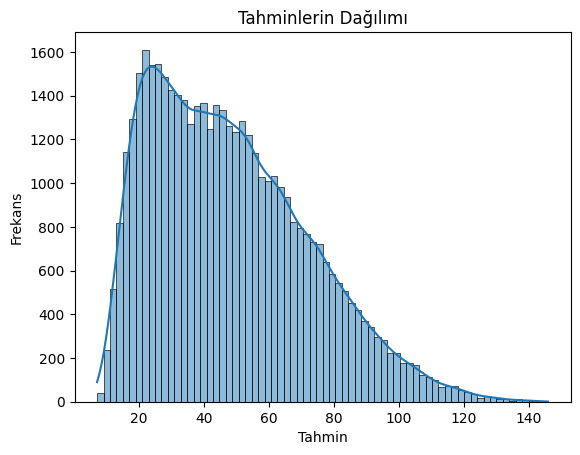

In [52]:
sns.histplot(y_preds_test, kde=True)
plt.title("Tahminlerin Dağılımı")
plt.xlabel("Tahmin")
plt.ylabel("Frekans")
plt.show()

# Visualization of Forecasts

In [53]:
train_final = pd.read_csv("/kaggle/input/demand-forecasting-kernels-only/train.csv")
test_final = pd.read_csv("/kaggle/input/demand-forecasting-kernels-only/test.csv")

In [54]:
df = pd.concat([train_final, test_final], sort=False)

In [55]:
df.sort_values(["store", "item", "date"], inplace = True)

train_final = df.loc[(df["date"] < "2018-01-01"), :]
test_final = df.loc[(df["date"] >= "2018-01-01"), :]

In [56]:
forecast = pd.DataFrame({
    "date":test_final.date,
    "store":test_final.store,
    "item":test_final.item,
    "sales":y_preds_test
})

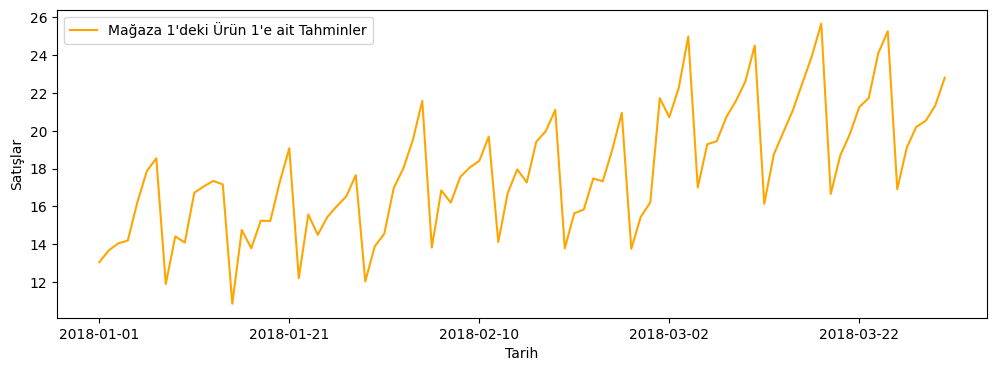

In [57]:
forecast[(forecast.store == 1) & (forecast.item == 1)].set_index("date").sales.\
plot(color = "orange", figsize = (12,4), legend=True, label = "Mağaza 1'deki Ürün 1'e ait Tahminler")
plt.xlabel("Tarih")
plt.ylabel("Satışlar")
plt.show()

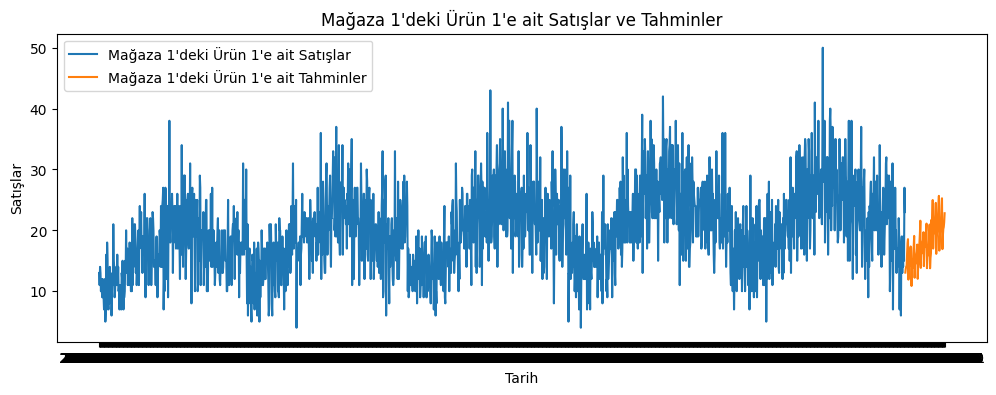

In [58]:
# Verileri filtreleme ve indeksleme
train_data = train_final[(train_final.store == 1) & (train_final.item == 1)].set_index("date")
forecast_data = forecast[(forecast.store == 1) & (forecast.item == 1)].set_index("date")

# Grafiği oluşturma
plt.figure(figsize=(12, 4))
sns.lineplot(data=train_data, x=train_data.index, y='sales', label="Mağaza 1'deki Ürün 1'e ait Satışlar")
sns.lineplot(data=forecast_data, x=forecast_data.index, y='sales', label="Mağaza 1'deki Ürün 1'e ait Tahminler")

# Başlık ve etiketleri ekleme
plt.title("Mağaza 1'deki Ürün 1'e ait Satışlar ve Tahminler")
plt.xlabel("Tarih")
plt.ylabel("Satışlar")
plt.legend()
plt.show()

## Feature Importance (Değişken Önem Düzeyleri)

In [59]:
def plot_lgm_importances(model, plot=False, num=10):
    gain = model.feature_importance("gain")
    feat_imp = pd.DataFrame({"feature": model.feature_name(), 
                             "split": model.feature_importance("split"), 
                             "gain": 100* gain / gain.sum()}).sort_values("gain", ascending=False)
    
    if plot:
        plt.figure(figsize=(5,5))
        sns.set(font_scale=1)
        sns.barplot(x="gain", y="feature", data=feat_imp[0:num])
        plt.title("feature")
        plt.tight_layout()
        plt.show()
    else:
        print(feat_imp.head(num))

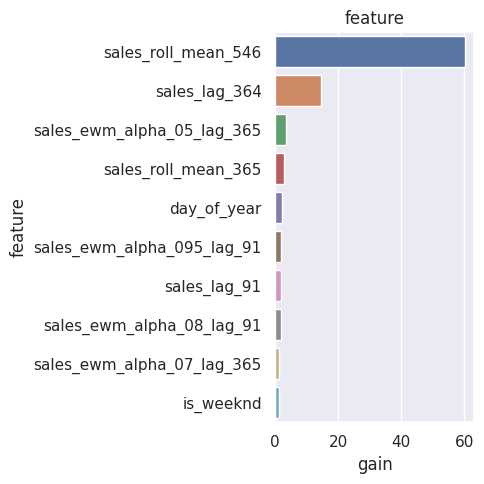

In [60]:
plot_lgm_importances(final_model, plot=True, num=10)